In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from LQN_igraph_copy import *
import itertools
from copy import deepcopy
import sympy as sp
from itertools import groupby

In [2]:
import igraph as ig
import hashlib

In [3]:
def epm_process(num_system, num_ancilla):
    graph_generator = EPM_bipartite_graph_generator_igraph(num_system, num_ancilla)
    canonical_groups = process_and_group_by_canonical_form(graph_generator)
    filtered_groups = filter_groups_by_scc_igraph(canonical_groups)
    unique_bigraph = extract_unique_bigraphs_from_groups_igraph(filtered_groups)
    return unique_bigraph

In [4]:
num_system = 3
num_ancilla = 1

In [5]:
canonical_groups = epm_process(num_system, num_ancilla)

In [6]:
list(canonical_groups.keys())

['218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8',
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a',
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d',
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d',
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac']

In [7]:
canonical_groups[list(canonical_groups.keys())[0]]

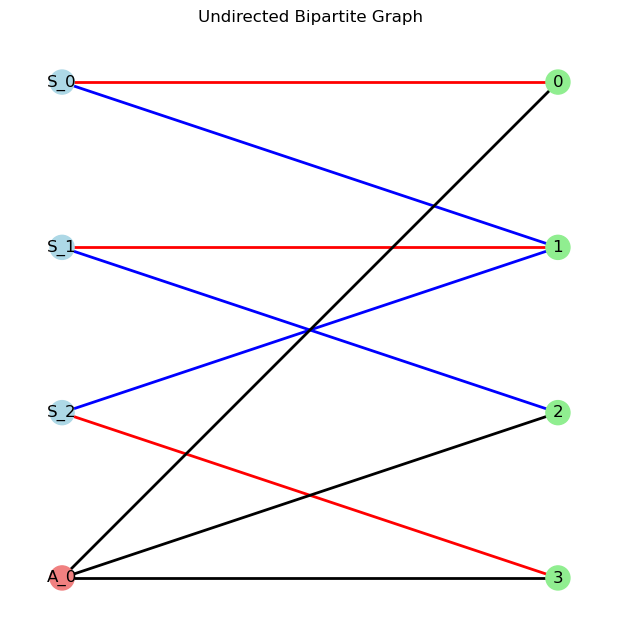

In [8]:
Draw_EPM_bipartite_graph(igraph_to_networkx(canonical_groups[list(canonical_groups.keys())[0]][2]))

In [14]:
import igraph as ig
from collections import Counter
from math import gcd
from functools import reduce

def is_perfect_matching(G, matching):
    """
    Check if a matching is a perfect matching for the graph.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
    matching : list
        List of edges in the matching
        
    Returns:
    --------
    bool
        True if the matching is perfect, False otherwise
    """
    # Perfect matching should cover half of the nodes in bipartite graph
    return len(matching) == len(G.vs) // 2

def get_bipartite_sets(G):
    """
    Extract the bipartite sets from igraph object.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
        
    Returns:
    --------
    tuple
        (U, V) where U and V are lists of node indices in each partition
    """
    # Check if graph has bipartite attribute
    if 'bipartite' in G.vs.attributes():
        U = [v.index for v in G.vs if v['bipartite'] == 0]
        V = [v.index for v in G.vs if v['bipartite'] == 1]
    elif 'category' in G.vs.attributes():
        # Extract based on category attribute (for EPM graphs)
        U = [v.index for v in G.vs if v['category'] in ['system_nodes', 'ancilla_nodes']]
        V = [v.index for v in G.vs if v['category'] == 'sculpting_nodes']
    else:
        # If not explicitly marked, try to infer bipartite structure
        # Assuming bipartite graph with equal sets
        n = len(G.vs) // 2
        U = list(range(0, n))
        V = list(range(n, 2*n))
    
    return U, V

def get_edge_weight(G, u, v):
    """
    Get weight of edge between u and v.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
    u : int
        Source node index
    v : int
        Target node index
        
    Returns:
    --------
    float or None
        Weight of the edge if it exists, None otherwise
    """
    eid = G.get_eid(u, v, error=False)
    if eid == -1:
        return None
    
    if 'weight' in G.es.attributes():
        # Just return the weight as is
        return G.es[eid]['weight']
    return '+'  # Default weight if not specified

def dfs_all_matchings(G, U, V, current_matching, all_matchings, all_weights, matched, u_index=0):
    """
    Use DFS to find all perfect matchings in a bipartite graph.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
    U : list
        List of node indices in the first partition
    V : list
        List of node indices in the second partition
    current_matching : list
        Current matching being built
    all_matchings : list
        List to store all perfect matchings found
    all_weights : list
        List to store weight strings for each perfect matching
    matched : dict
        Dictionary keeping track of which nodes are matched
    u_index : int, optional
        Current index in U to start from (default: 0)
    """
    if is_perfect_matching(G, current_matching):
        all_matchings.append(current_matching[:])
        
        # Map weights to corresponding quantum states:
        # weight 1.0 -> state 0
        # weight 2.0 -> state 1
        # weight 3.0 -> state 2 (if needed)
        weights_list = []
        for u, v, w in current_matching:
            if w == 1.0:
                weights_list.append('0')
            elif w == 2.0:
                weights_list.append('1')
            elif w == 3.0:
                # Include state 2 only if we want to represent ancilla
                # Currently skipping as per previous requirement
                pass
        
        matching_key = ''.join(weights_list)
        all_weights.append(matching_key)
        return

    # Start from current index to avoid redundant checks
    for i in range(u_index, len(U)):
        u = U[i]
        if matched[u]:
            continue

        for v in V:
            if not matched[v]:
                # Check if edge exists
                weight = get_edge_weight(G, u, v)
                if weight is not None:
                    current_matching.append((u, v, weight))
                    matched[u] = True
                    matched[v] = True

                    # Recursive call with next index
                    dfs_all_matchings(G, U, V, current_matching, all_matchings, all_weights, matched, i + 1)

                    # Backtrack
                    matched[u] = False
                    matched[v] = False
                    current_matching.pop()

def find_all_perfect_matchings(G):
    """
    Find all perfect matchings in a bipartite graph.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
        
    Returns:
    --------
    tuple
        (all_matchings, all_weights) where:
        - all_matchings is a list of perfect matchings
        - all_weights is a list of weight strings for each matching
    """
    U, V = get_bipartite_sets(G)
    all_matchings = []
    all_weights = []
    matched = {node: False for node in range(len(G.vs))}

    dfs_all_matchings(G, U, V, [], all_matchings, all_weights, matched)
    
    return all_matchings, all_weights

def find_unused_edges(G, perfect_matchings):
    """
    Find edges that are not used in any perfect matching.
    
    Parameters:
    -----------
    G : igraph.Graph
        The bipartite graph
    perfect_matchings : list
        List of perfect matchings
        
    Returns:
    --------
    list
        List of edges (as tuples) that are not used in any perfect matching
    """
    # Create a set of all edges used in any perfect matching
    used_edges = set()
    for matching in perfect_matchings:
        for u, v, _ in matching:
            used_edges.add((u, v))
            used_edges.add((v, u))  # Add both directions since igraph may use either

    # Find unused edges
    unused_edges = []
    for edge in G.es:
        edge_tuple = (edge.source, edge.target)
        if edge_tuple not in used_edges:
            unused_edges.append(edge_tuple)
    
    return unused_edges

def find_pm_of_bigraph(graph_list):
    """
    Find perfect matchings for each graph in the list.
    
    Parameters:
    -----------
    graph_list : list
        List of igraph.Graph objects
        
    Returns:
    --------
    list
        List of [Counter(weight_strings), perfect_matchings, graph, index] for valid graphs
    """
    save_fw_results = []

    for i, G in enumerate(graph_list):
        perfect_matching_result, weight_strings = find_all_perfect_matchings(G)
        
        if not find_unused_edges(G, perfect_matching_result) and len(perfect_matching_result) >= 2:
            save_fw_results.append([
                Counter(weight_strings),
                perfect_matching_result,
                G,
                i  # Index in the original graph list
            ])
    
    # Normalize coefficients using GCD
    for i in save_fw_results:
        values = list(i[0].values())
        if values:
            gcd_of_values = reduce(gcd, values)
            for key in i[0]:
                i[0][key] //= gcd_of_values
    
    return save_fw_results

def remove_same_state(save_fw_results):
    """
    Remove duplicate states based on weight counters.
    
    Parameters:
    -----------
    save_fw_results : list
        List of [Counter(weight_strings), perfect_matchings, graph, index]
        
    Returns:
    --------
    list
        List of unique entries based on state counter
    """
    seen = set()
    unique_counters = []

    for counter in save_fw_results:
        counter_tuple = tuple(sorted(counter[0].items()))
        
        if counter_tuple not in seen:
            seen.add(counter_tuple)
            unique_counters.append(counter)
    
    return unique_counters

def process_graph_dict(graph_dict):
    """
    Process dictionary of graphs to find states.
    
    Parameters:
    -----------
    graph_dict : dict
        Dictionary mapping hash keys to lists of igraph.Graph objects
        
    Returns:
    --------
    dict
        Dictionary mapping hash keys to lists of [Counter, matchings, graph, index]
    """
    result_dict = {}
    
    for hash_key, graph_list in graph_dict.items():
        # Find perfect matchings for this graph list
        fw_results = find_pm_of_bigraph(graph_list)
        
        # Remove duplicate states
        unique_results = remove_same_state(fw_results)
        
        # Add to result dictionary
        if unique_results:
            result_dict[hash_key] = unique_results
    
    return result_dict

def check_quantum_states_exist(result_dict, target_states, hash_key=None):
    """
    Check if all specified quantum states exist in the results.
    
    Parameters:
    -----------
    result_dict : dict
        Result dictionary returned from process_graph_dict() function
    target_states : list or str
        List of quantum states to search for (e.g. ['0101', '1010']) or a single state as string
    hash_key : str, optional
        Specific hash key to search within (default: None, search all hashes)
        
    Returns:
    --------
    list
        [(hash_key, {state1: coefficient1, state2: coefficient2, ...}, graph_index), ...] 
        List of results where all target states exist:
        - hash_key: Hash key where the states were found
        - state_coefficients: Dictionary of states and their coefficients
        - graph_index: Index in the original graph list
    """
    results = []
    
    # Convert single state string to list for consistent processing
    if isinstance(target_states, str):
        target_states = [target_states]
    
    # Determine which hash keys to search
    if hash_key is not None:
        if hash_key not in result_dict:
            return []
        hash_keys = [hash_key]
    else:
        hash_keys = result_dict.keys()
    
    # Search through each hash key
    for key in hash_keys:
        for state_data in result_dict[key]:
            counter = state_data[0]  # State coefficient Counter
            graph_index = state_data[3]  # Graph index
            
            # Check if all target states exist in this counter
            all_states_exist = all(state in counter for state in target_states)
            
            if all_states_exist:
                # Create dictionary of states and their coefficients
                state_coefficients = {state: counter[state] for state in target_states}
                results.append((key, state_coefficients, graph_index))
    
    return results

def get_all_quantum_states(result_dict, hash_key=None):
    """
    Returns all quantum states found in the results.
    
    Parameters:
    -----------
    result_dict : dict
        Result dictionary returned from process_graph_dict() function
    hash_key : str, optional
        Specific hash key to search within (default: None, search all hashes)
        
    Returns:
    --------
    dict
        {hash_key: {state: [(coefficient, graph_index), ...], ...}, ...}
        Dictionary mapping each hash key to its states and occurrences
    """
    states_dict = {}
    
    # Determine which hash keys to search
    if hash_key is not None:
        if hash_key not in result_dict:
            return {}
        hash_keys = [hash_key]
    else:
        hash_keys = result_dict.keys()
    
    # Collect states from each hash key
    for key in hash_keys:
        states_dict[key] = {}
        
        for state_data in result_dict[key]:
            counter = state_data[0]  # State coefficient Counter
            graph_index = state_data[3]  # Graph index
            
            # Store all states
            for state, coefficient in counter.items():
                if state not in states_dict[key]:
                    states_dict[key][state] = []
                states_dict[key][state].append((coefficient, graph_index))
    
    return states_dict

# Example usage:
# graph_dict = {
#     'hash1': [graph1, graph2, ...],
#     'hash2': [graph3, graph4, ...],
# }
# result = process_graph_dict(graph_dict)
# 
# # Search for multiple quantum states
# # Returns only results where all specified states exist
# states_to_find = ['010', '101']
# state_results = check_quantum_states_exist(result, states_to_find)
# for hash_key, state_coefficients, graph_index in state_results:
#     print(f"All states {states_to_find} found in hash {hash_key} (graph index: {graph_index})")
#     for state, coefficient in state_coefficients.items():
#         print(f"  State '{state}' has coefficient {coefficient}")
#
# # Search for a single state
# single_state = '0101'
# single_results = check_quantum_states_exist(result, single_state)
# for hash_key, state_coefficients, graph_index in single_results:
#     print(f"State '{single_state}' found in hash {hash_key} with coefficient {state_coefficients[single_state]}")
#
# # Get all quantum states
# all_states = get_all_quantum_states(result)
# for hash_key, states in all_states.items():
#     print(f"\nHash: {hash_key}")
#     for state, occurrences in states.items():
#         print(f"  State: {state}, Found {len(occurrences)} times")
#         for coefficient, graph_index in occurrences:
#             print(f"    - Coefficient: {coefficient}, Graph index: {graph_index}")

In [15]:
# graph_dict contains your dictionary of igraph objects
result_dict = process_graph_dict(canonical_groups)

# Accessing results
for hash_key, states in result_dict.items():
    print(f"Hash: {hash_key}")
    for state in states:
        counter, matchings, graph, index = state
        print(f"  State coefficients: {dict(counter)}")

Hash: 218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8
  State coefficients: {'011': 1, '101': 1, '110': 1}
  State coefficients: {'010': 1, '100': 1, '111': 1}
  State coefficients: {'000': 1, '011': 1, '110': 1}
  State coefficients: {'010': 1, '001': 1, '100': 1}
Hash: a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a
  State coefficients: {'011': 1, '101': 1, '110': 1, '111': 1}
  State coefficients: {'010': 1, '100': 1, '111': 1, '110': 1}
  State coefficients: {'000': 1, '011': 1, '010': 1, '110': 1}
  State coefficients: {'010': 1, '001': 1, '000': 1, '100': 1}
Hash: 7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d
  State coefficients: {'010': 1, '101': 1}
  State coefficients: {'011': 1, '100': 1}
  State coefficients: {'000': 1, '111': 1}
  State coefficients: {'001': 1, '110': 1}
Hash: be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d
  State coefficients: {'010': 1, '101': 1, '111': 1}
  State coefficients: {'010

In [16]:
list(result_dict.keys())

['218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8',
 'a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a',
 '7959e8b9b6367ea841c063652027ca3291a2759513b05897bde6c9a55b5a0d2d',
 'be5bb5d27c1163901bda31341e09f4b222ee2a792371c9f3ed04b0e6fa1f8c1d',
 '0bd32b8e4d20824cbd28a77b586a28f3476cd8be323a986e5039a815fe05c0ac']

In [17]:
result_dict[list(result_dict.keys())[0]][0]

[Counter({'011': 1, '101': 1, '110': 1}),
 [[(0, 4, 1.0), (1, 6, 2.0), (2, 7, 2.0), (3, 5, 3.0)],
  [(0, 5, 2.0), (1, 4, 1.0), (2, 7, 2.0), (3, 6, 3.0)],
  [(0, 5, 2.0), (1, 6, 2.0), (2, 4, 1.0), (3, 7, 3.0)]],
 0]

In [18]:
result_dict[list(result_dict.keys())[0]][0][2]

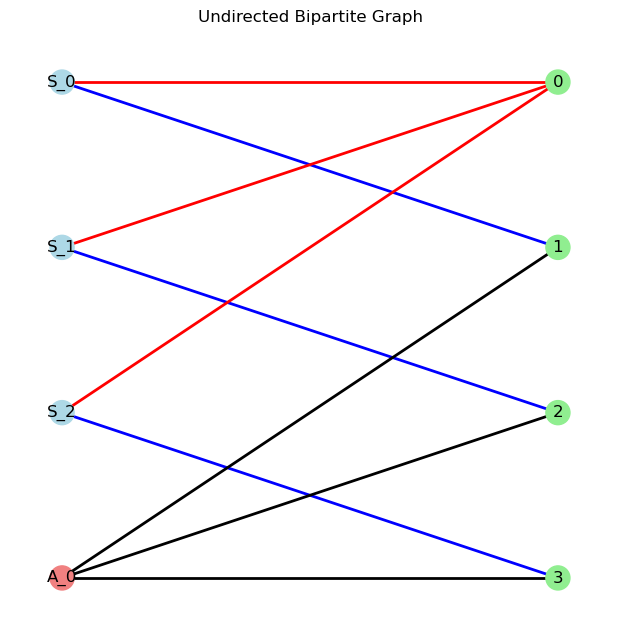

In [19]:
Draw_EPM_bipartite_graph(igraph_to_networkx(result_dict[list(result_dict.keys())[0]][0][2]))

In [20]:
target = ['011', '101', '110']

In [21]:
state_results = check_quantum_states_exist(result_dict, target)

In [22]:
state_results

[('218e6398a9fa515ded106c4cffca4e4cd8b0055519fe788c78516ac7d2a102f8',
  {'011': 1, '101': 1, '110': 1},
  0),
 ('a2b0625305e51c00c5048d17e1a280ff7795dffe1aa358d5676a595e144bb28a',
  {'011': 1, '101': 1, '110': 1},
  0)]